In [287]:
import re
import ast
import pickle
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from utils_martina.my_utils import *

## Info

In [288]:
index_evaluator = 1

In [289]:
# Set patient and record

# observations = ["chb03_01", "chb03_02", "chb03_03", "chb03_04", "chb03_34", "chb03_35", "chb03_36"]

patient_id = "chb04"
record_id = "28"

# patient_id = "PN14"
# record_id = "4"

In [290]:
# file_name = '16536-Martina'

In [291]:
if patient_id[:2] == "PN":      # Frequency Siena dataset
    frequency = 512
elif patient_id[:3] == "chb":   # Frequency CHB-MIT dataset
    frequency = 256

## Load data

In [292]:
# Load information related to the EEG of patient_id, record_id
with open(f"EEG_data\EEG_data_params_{patient_id}_{record_id}.pkl", "rb") as f:
    loaded_variables = pickle.load(f)

indices = loaded_variables["indici"]
Start = loaded_variables["Start"]
End = loaded_variables["End"]
seizure_starts = loaded_variables["seizure_starts"]
seizure_ends = loaded_variables["seizure_ends"]
seizure_class = loaded_variables["seizure_class"]

In [293]:
logs_path = "..\\..\\explainability\GRETEL-repo\\output\\logs\\"
eval_manager_path = "..\\..\\explainability\GRETEL-repo\\output\\eval_manager\\"
output_path = "..\\..\\explainability\GRETEL-repo\\output\\metrics\\"

In [294]:
file_name = get_most_recent_file(eval_manager_path).split('.')[0]
print(file_name)

19608-Martina


In [295]:
# Load logs
with open(logs_path + file_name + '.info', "r") as file:
    content = file.read()

# Load eval_manager
with open(eval_manager_path + file_name + '.pkl', 'rb') as f:
    eval_manager = pickle.load(f)

In [296]:
for i in range(len(eval_manager._evaluators)):
    if i == index_evaluator:
        print(f"---> {eval_manager._evaluators[i]._explainer.name}")
    else:
        print(f"     {eval_manager._evaluators[i]._explainer.name}")

     RSGG-b2ce86000f4debf05dbbd8354d36cf72
---> DCESExplainer-ba8e48b9ebb10958880965bcab2b5bbf
     DataDrivenBidirectionalSearchExplainer-c19b78b84f2b54f3b02ac1d423df889b
     ObliviousBidirectionalSearchExplainer-3cb49bec6c6c803d632c638db960d3b8


### Oracle and explainer metrics

In [297]:
# Creating a dictionary for each metric
RuntimeMetric = extract_dictionary_from_runtime_metric(content,"RuntimeMetric",i=index_evaluator)
GraphEditDistanceMetric = extract_dictionary_from_runtime_metric(content,"GraphEditDistanceMetric",i=index_evaluator)
OracleCallsMetric = extract_dictionary_from_runtime_metric(content,"OracleCallsMetric",i=index_evaluator)
CorrectnessMetric = extract_dictionary_from_runtime_metric(content,"CorrectnessMetric",i=index_evaluator)
SparsityMetric = extract_dictionary_from_runtime_metric(content,"SparsityMetric",i=index_evaluator)
FidelityMetric = extract_dictionary_from_runtime_metric(content,"FidelityMetric",i=index_evaluator)
OracleAccuracyMetric = extract_dictionary_from_runtime_metric(content,"OracleAccuracyMetric",i=index_evaluator)
EmbeddingMetric = extract_dictionary_from_runtime_metric(content,"EmbeddingMetric",i=index_evaluator)

# Extraction of times and records
dict_time, dict_record = extract_time_and_record(content,i=index_evaluator)

In [298]:
# Extracting data of desired record
RuntimeMetric = {id: value for id, value in RuntimeMetric.items() if dict_record[id] == f"{patient_id}_{record_id}"}
GraphEditDistanceMetric = {id: value for id, value in GraphEditDistanceMetric.items() if dict_record[id] == f"{patient_id}_{record_id}"}
OracleCallsMetric = {id: value for id, value in OracleCallsMetric.items() if dict_record[id] == f"{patient_id}_{record_id}"}
CorrectnessMetric = {id: value for id, value in CorrectnessMetric.items() if dict_record[id] == f"{patient_id}_{record_id}"}
SparsityMetric = {id: value for id, value in SparsityMetric.items() if dict_record[id] == f"{patient_id}_{record_id}"}
FidelityMetric = {id: value for id, value in FidelityMetric.items() if dict_record[id] == f"{patient_id}_{record_id}"}
OracleAccuracyMetric = {id: value for id, value in OracleAccuracyMetric.items() if dict_record[id] == f"{patient_id}_{record_id}"}
EmbeddingMetric = {id: value for id, value in EmbeddingMetric.items() if dict_record[id] == f"{patient_id}_{record_id}"}

In [299]:
# Calculation of time instants associated with the graphs
id_graphs = [id for id, value in dict_record.items() if value == f"{patient_id}_{record_id}"]
time_graphs = [dict_time[id] for id in id_graphs]

indices_test = []
times_test = []

for id in time_graphs:
    indices_test.append(indices[id])
    times_test.append(indices[id]/frequency + Start)

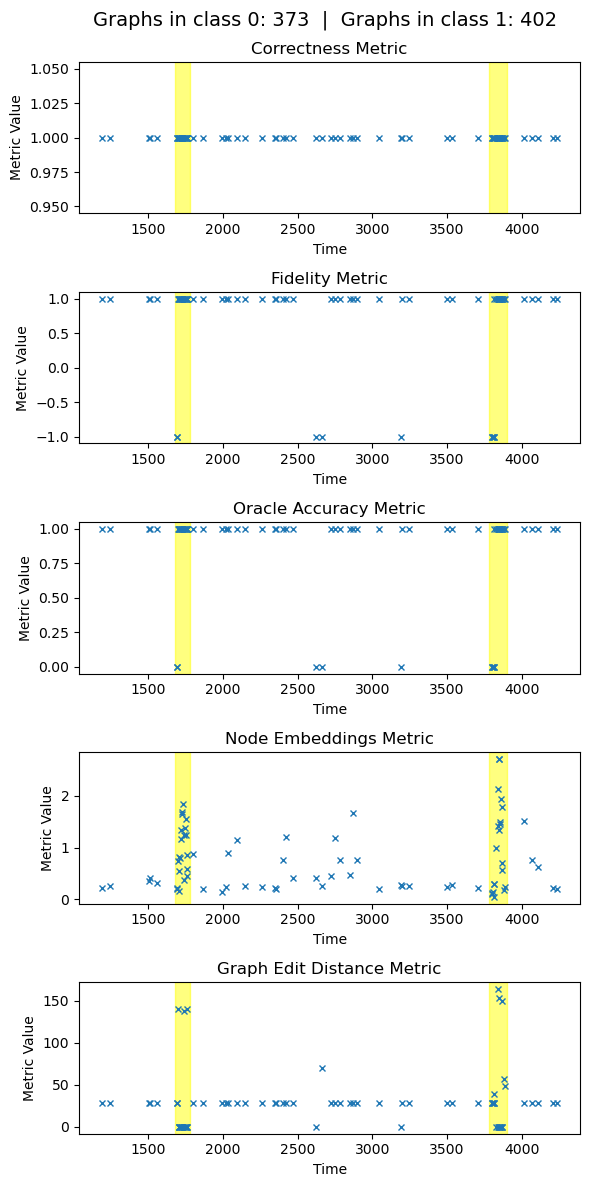

In [300]:
# Function to plot vertical bands for seizure conditions
def add_seizure_shading(ax, starts, ends, also_horizontal=False):
    for start, end in zip(starts, ends):
        ax.axvspan(start, end, color='yellow', alpha=0.5)

        if also_horizontal:
            ax.axhspan(start, end, color='orange', alpha=0.5)

fig, axes = plt.subplots(5, 1, figsize=(6,12))

# Subplot 1: CorrectnessMetric
add_seizure_shading(axes[0], seizure_starts, seizure_ends)
axes[0].plot(times_test, np.array(list(CorrectnessMetric.values())), marker='x', linestyle='', markersize=5, label='Correctness')
axes[0].set_title('Correctness Metric')

# Subplot 2: FidelityMetric
add_seizure_shading(axes[1], seizure_starts, seizure_ends)
axes[1].plot(times_test, np.array(list(FidelityMetric.values())), marker='x', linestyle='', markersize=5, label='Fidelity')
axes[1].set_title('Fidelity Metric')

# Subplot 3: OracleAccuracyMetric
add_seizure_shading(axes[2], seizure_starts, seizure_ends)
axes[2].plot(times_test, np.array(list(OracleAccuracyMetric.values())), marker='x', linestyle='', markersize=5, label='Oracle Accuracy')
axes[2].set_title('Oracle Accuracy Metric')

# Subplot 4: EmbeddingsMetric
add_seizure_shading(axes[3], seizure_starts, seizure_ends)
axes[3].plot(times_test, np.array(list(EmbeddingMetric.values())), marker='x', linestyle='', markersize=5, label='Node Embeddings Metric')
axes[3].set_title('Node Embeddings Metric')

# Subplot 5: GraphEditDistanceMetric
add_seizure_shading(axes[4], seizure_starts, seizure_ends)
axes[4].plot(times_test, np.array(list(GraphEditDistanceMetric.values())), marker='x', linestyle='', markersize=5, label='Graph Edit Distance Metric')
axes[4].set_title('Graph Edit Distance Metric')

for ax in axes:
    ax.set_xlabel('Time')
    ax.set_ylabel('Metric Value')
    # ax.set_xlim((Start,End))

text = f"Graphs in class 0: {seizure_class.count(0)}  |  Graphs in class 1: {seizure_class.count(1)}"
fig.suptitle(text, fontsize=14, x=0.55, y=0.985)
plt.tight_layout()
plt.savefig(f"{output_path}{file_name.split('-')[0]}-{patient_id}_{record_id}_{(eval_manager._evaluators[index_evaluator]._explainer.name).split('-')[0]}.png", dpi=300)
plt.show()

## Density

In [301]:
# Funzione per estrarre l'elemento desiderato in base all'indice
def get_other_info(content,metric,i=0):

    # Trova tutte le occorrenze del dizionario
    occurrences = content.split(metric)[1:]

    # Converti ogni occorrenza in una lista di dizionari
    records = []
    for occ in occurrences:
        # Cerca la parte che inizia con '[{' (lista di dizionari) e termina con '}]'
        start_idx = occ.find("[{")
        end_idx = occ.find("}]") + 2  # Include la parentesi di chiusura ']}'
        
        if start_idx != -1 and end_idx != -1:
            dict_part = occ[start_idx:end_idx]
            # Usa ast.literal_eval per trasformare il testo in un oggetto Python (lista di dizionari)
            records.append(ast.literal_eval(dict_part))
    
    # Estrai l'elemento corrispondente all'indice i
    if i < len(records) and i >= 0:
        list = records[i]
        return list
    else:
        return None  # Se l'indice è fuori dai limiti

In [302]:
# def get_other_info(content, search):
#     # Function to extract graph metrics
#     for line in content.splitlines():
#         if search in line:
#             match = re.search(r'(\[.*\])', line)
#             if match:
#                 json_str = match.group(1)
#                 json_data = ast.literal_eval(json_str)
#                 return json_data

graph_metrics = get_other_info(content, 'graph_metrics',i=index_evaluator)
graph_metrics = [entry for entry in graph_metrics if dict_record[str(entry['instance_id'])] == f"{patient_id}_{record_id}"]

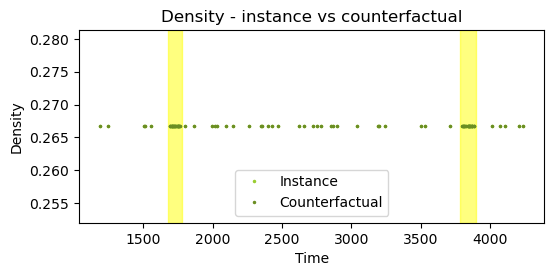

In [303]:
# Plot of the density
fig, ax = plt.subplots(figsize=(6,2.5))

add_seizure_shading(ax, seizure_starts, seizure_ends)
ax.plot(times_test, np.array([entry['density_instance'] for entry in graph_metrics]), marker='.', color='yellowgreen', linestyle='', markersize=3, label='Instance')
ax.plot(times_test, np.array([entry['density_counterfactual'] for entry in graph_metrics]), marker='.', color='olivedrab', linestyle='', markersize=3, label='Counterfactual')
ax.set_title('Density - instance vs counterfactual')
ax.set_xlabel('Time')
ax.set_ylabel('Density')
ax.legend() # ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

## Number of edges

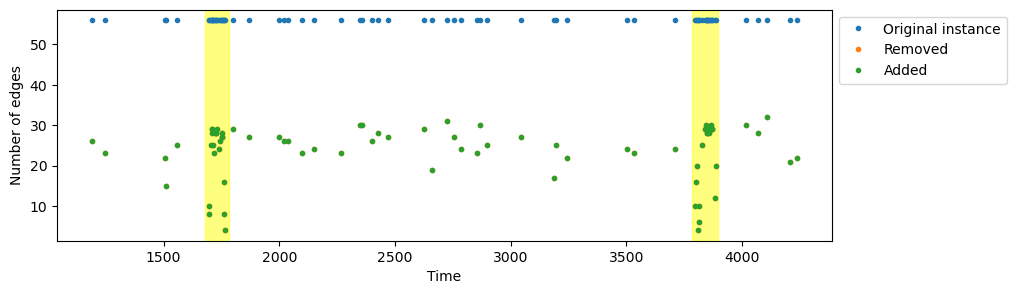

In [304]:
def get_number_edges(evaluator):
    result = []

    for g1, g2 in evaluator.get_instance_explanation_pairs():
        # Create graphs from adjacency matrices
        G_orig = nx.from_numpy_array(g1.data)

        # Difference between adjacency matrices
        A_diff = g1.data - g2.data
        edges_added = nx.from_numpy_array(A_diff == -1)
        edges_removed = nx.from_numpy_array(A_diff == 1)

        result.append({ 'id': g1.id, 'patient_record': f"{g1.patient_id}_{g1.record_id}", 'original': G_orig.number_of_edges(), 'added': edges_added.number_of_edges(), 'removed': edges_removed.number_of_edges() })
    
    return result

def plot_and_number_edges(evaluator, times_test):
    a = get_number_edges(evaluator)
    a = [entry for entry in a if entry['patient_record'] == f"{patient_id}_{record_id}"]

    original = [entry['original'] for entry in a]
    added = [entry['added'] for entry in a]
    removed = [entry['removed'] for entry in a]

    fig, ax = plt.subplots(1,figsize=(10,3))
    ax.plot(times_test, original, label='Original instance', marker='.', linestyle='')
    ax.plot(times_test, removed, label='Removed', marker='.', linestyle='')
    ax.plot(times_test, added, label='Added', marker='.', linestyle='')

    add_seizure_shading(ax, seizure_starts, seizure_ends)

    ax.set_xlabel('Time')
    ax.set_ylabel('Number of edges')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.savefig(f"{output_path}{file_name.split('-')[0]}-{patient_id}_{record_id}_{(eval_manager._evaluators[index_evaluator]._explainer.name).split('-')[0]}_EDGES.png", dpi=300)
    plt.show()

    return [r + a for r, a in zip(removed, added)]

modified_edges = plot_and_number_edges(eval_manager._evaluators[index_evaluator], times_test)

In [305]:
with open(f"{output_path}GED\\{file_name.split('-')[0]}-{patient_id}_{record_id}_{(eval_manager._evaluators[index_evaluator]._explainer.name).split('-')[0]}.pkl", 'wb') as f:
    pickle.dump({'times_test': times_test, 'modified_edges': modified_edges}, f)

## _______________________________________________________________

In [306]:
import datetime

now = datetime.datetime.now()
print("Last full run:", now.strftime("%d/%m/%Y, ore %H:%M"))

Last full run: 10/04/2025, ore 22:31
